# 🎄 Santa 2025 — Optimization Trick - fix direction

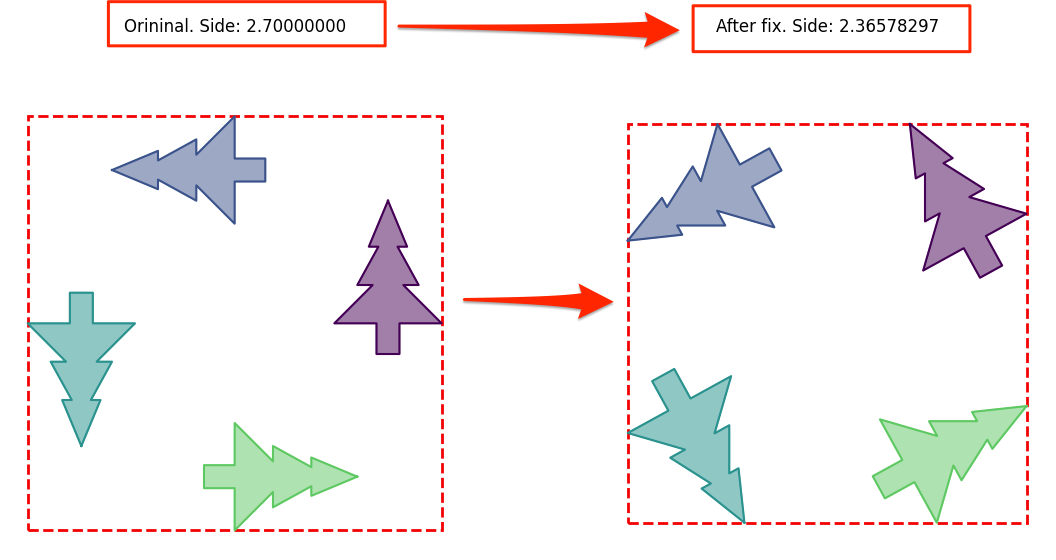

# Helper functions

In [ ]:
import pandas as pd
from decimal import Decimal, getcontext
from shapely import affinity, touches
from shapely.geometry import Polygon
from shapely.ops import unary_union
from shapely.strtree import STRtree

getcontext().prec = 25
scale_factor = 1

In [ ]:
class ChristmasTree:
    """Represents a single, rotatable Christmas tree of a fixed size."""

    def __init__(self, center_x='0', center_y='0', angle='0'):
        """Initializes the Christmas tree with a specific position and rotation."""
        self.center_x = Decimal(center_x)
        self.center_y = Decimal(center_y)
        self.angle = Decimal(angle)

        trunk_w = Decimal('0.15')
        trunk_h = Decimal('0.2')
        base_w = Decimal('0.7')
        mid_w = Decimal('0.4')
        top_w = Decimal('0.25')
        tip_y = Decimal('0.8')
        tier_1_y = Decimal('0.5')
        tier_2_y = Decimal('0.25')
        base_y = Decimal('0.0')
        trunk_bottom_y = -trunk_h

        initial_polygon = Polygon(
            [
                # Start at Tip
                (Decimal('0.0') * scale_factor, tip_y * scale_factor),
                # Right side - Top Tier
                (top_w / Decimal('2') * scale_factor, tier_1_y * scale_factor),
                (top_w / Decimal('4') * scale_factor, tier_1_y * scale_factor),
                # Right side - Middle Tier
                (mid_w / Decimal('2') * scale_factor, tier_2_y * scale_factor),
                (mid_w / Decimal('4') * scale_factor, tier_2_y * scale_factor),
                # Right side - Bottom Tier
                (base_w / Decimal('2') * scale_factor, base_y * scale_factor),
                # Right Trunk
                (trunk_w / Decimal('2') * scale_factor, base_y * scale_factor),
                (trunk_w / Decimal('2') * scale_factor, trunk_bottom_y * scale_factor),
                # Left Trunk
                (-(trunk_w / Decimal('2')) * scale_factor, trunk_bottom_y * scale_factor),
                (-(trunk_w / Decimal('2')) * scale_factor, base_y * scale_factor),
                # Left side - Bottom Tier
                (-(base_w / Decimal('2')) * scale_factor, base_y * scale_factor),
                # Left side - Middle Tier
                (-(mid_w / Decimal('4')) * scale_factor, tier_2_y * scale_factor),
                (-(mid_w / Decimal('2')) * scale_factor, tier_2_y * scale_factor),
                # Left side - Top Tier
                (-(top_w / Decimal('4')) * scale_factor, tier_1_y * scale_factor),
                (-(top_w / Decimal('2')) * scale_factor, tier_1_y * scale_factor),
            ]
        )
        rotated = affinity.rotate(initial_polygon, float(self.angle), origin=(0, 0))
        self.polygon = affinity.translate(rotated,
                                          xoff=float(self.center_x * scale_factor),
                                          yoff=float(self.center_y * scale_factor))
        

    def clone(self) -> "ChristmasTree":
        return ChristmasTree(
            center_x=str(self.center_x),
            center_y=str(self.center_y),
            angle=str(self.angle),
        )    

def get_tree_list_side_lenght(tree_list: list[ChristmasTree]) -> Decimal:
    all_polygons = [t.polygon for t in tree_list]
    bounds = unary_union(all_polygons).bounds
    return Decimal(max(bounds[2] - bounds[0], bounds[3] - bounds[1])) / scale_factor

def get_total_score(dict_of_side_length: dict[str, Decimal]):
    score = 0
    for k, v in dict_of_side_length.items():
        score += v ** 2 / Decimal(k)
    return score

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def plot_layout(ax, placed_trees, title):
    num_trees = len(placed_trees)
    colors = plt.cm.viridis([i / num_trees for i in range(num_trees)])

    all_polygons = [t.polygon for t in placed_trees]
    bounds = unary_union(all_polygons).bounds

    for i, tree in enumerate(placed_trees):
        # Rescale for plotting
        x_scaled, y_scaled = tree.polygon.exterior.xy
        x = [Decimal(val) / scale_factor for val in x_scaled]
        y = [Decimal(val) / scale_factor for val in y_scaled]
        ax.plot(x, y, color=colors[i])
        ax.fill(x, y, alpha=0.5, color=colors[i])

    minx = Decimal(bounds[0]) / scale_factor
    miny = Decimal(bounds[1]) / scale_factor
    maxx = Decimal(bounds[2]) / scale_factor
    maxy = Decimal(bounds[3]) / scale_factor

    width = maxx - minx
    height = maxy - miny
    # side_length = max(width, height)

    side_length = width if width > height else height
    

    square_x = minx if width >= height else minx - (side_length - width) / 2
    square_y = miny if height >= width else miny - (side_length - height) / 2
    bounding_square = Rectangle(
        (float(square_x), float(square_y)),
        float(side_length),
        float(side_length),
        fill=False,
        edgecolor='red',
        linewidth=2,
        linestyle='--',
    )
    ax.add_patch(bounding_square)

    padding = 0.5
    ax.set_xlim(
        float(square_x - Decimal(str(padding))),
        float(square_x + side_length + Decimal(str(padding))))
    ax.set_ylim(float(square_y - Decimal(str(padding))),
                float(square_y + side_length + Decimal(str(padding))))
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')
    ax.set_title(f'{title}. Side: {side_length:0.8f}')

def plot_difference(layout1, layout2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    plot_layout(ax1, layout1, "Orininal")
    plot_layout(ax2, layout2, "After fix")
    plt.tight_layout()
    plt.show()

def parse_csv(csv_path) -> dict[str, list[ChristmasTree]]:
    print(f'parse_csv: {csv_path=}')

    result = pd.read_csv(csv_path)
    result['x'] = result['x'].str.strip('s')
    result['y'] = result['y'].str.strip('s')
    result['deg'] = result['deg'].str.strip('s')
    result[['group_id', 'item_id']] = result['id'].str.split('_', n=2, expand=True)

    dict_of_tree_list = {}
    dict_of_side_length = {}
    for group_id, group_data in result.groupby('group_id'):
        tree_list = [ChristmasTree(center_x=row['x'], center_y=row['y'], angle=row['deg']) for _, row in group_data.iterrows()]
        dict_of_tree_list[group_id] = tree_list
        dict_of_side_length[group_id] = get_tree_list_side_lenght(tree_list)

    return dict_of_tree_list, dict_of_side_length

In [ ]:
from scipy.spatial import ConvexHull
from scipy.optimize import minimize_scalar
import numpy as np

def calculate_bbox_side_at_angle(angle_deg, points):
    angle_rad = np.radians(angle_deg)
    c, s = np.cos(angle_rad), np.sin(angle_rad)
    rot_matrix_T = np.array([[c, s], [-s, c]])
    rotated_points = points.dot(rot_matrix_T)
    min_xy = np.min(rotated_points, axis=0); max_xy = np.max(rotated_points, axis=0)
    return max(max_xy[0] - min_xy[0], max_xy[1] - min_xy[1])

def optimize_rotation(trees):
    all_points = []
    for tree in trees: all_points.extend(list(tree.polygon.exterior.coords))
    points_np = np.array(all_points)
    
    hull_points = points_np[ConvexHull(points_np).vertices]
    
    initial_side = calculate_bbox_side_at_angle(0, hull_points)
    
    res = minimize_scalar(lambda a: calculate_bbox_side_at_angle(a, hull_points), bounds=(0.001, 89.999), method='bounded')
    found_angle_deg = res.x
    found_side = res.fun
    
    improvement = initial_side - found_side
    
    EPSILON = 1e-5

    if improvement > EPSILON:
        best_angle_deg = found_angle_deg
        best_side = Decimal(found_side) / scale_factor
    else:
        best_angle_deg = 0.0
        best_side = Decimal(initial_side) / scale_factor
        
    return best_side, best_angle_deg

def apply_rotation(trees, angle_deg):
    if not trees or abs(angle_deg) < 1e-9: return [t.clone() for t in trees]
    
    bounds = [t.polygon.bounds for t in trees]
    min_x = min(b[0] for b in bounds); min_y = min(b[1] for b in bounds)
    max_x = max(b[2] for b in bounds); max_y = max(b[3] for b in bounds)
    rotation_center = np.array([(min_x + max_x) / 2.0, (min_y + max_y) / 2.0])
    
    angle_rad = np.radians(angle_deg)
    c, s = np.cos(angle_rad), np.sin(angle_rad)
    rot_matrix = np.array([[c, -s], [s, c]])
    
    points = np.array([[float(t.center_x), float(t.center_y)] for t in trees])
    shifted = points - rotation_center
    rotated = shifted.dot(rot_matrix.T) + rotation_center
    
    rotated_trees = []
    for i in range(len(trees)):
        new_tree = ChristmasTree(Decimal(rotated[i, 0]) , Decimal(rotated[i, 1]), Decimal(trees[i].angle + Decimal(angle_deg)))
        rotated_trees.append(new_tree)
    return rotated_trees

# Demo

In [ ]:
initial_trees = [
    ChristmasTree(1, 0, 0),      # Смотрит вправо (0°)
    ChristmasTree(0, 1, 90),     # Смотрит вверх (90°)
    ChristmasTree(-1, 0, 180),   # Смотрит влево (180°)
    ChristmasTree(0, -1, 270)    # Смотрит вниз (270°)
]

best_side, best_angle_deg = optimize_rotation(initial_trees)
fixed_trees = apply_rotation(initial_trees, best_angle_deg)

plot_difference(initial_trees, fixed_trees)

# Load solution we want to optimize (for example current best from public): 

In [ ]:
# Load current best solution
current_solution_path = '/kaggle/input/santa-2025-best-submission/submission.csv'
dict_of_tree_list, dict_of_side_length = parse_csv(current_solution_path)

# Calculate current total score
current_score = get_total_score(dict_of_side_length)
print(f'\n{current_score=:0.8f}')

# Execute optimization for all existing tree layouts

In [ ]:
for group_id_main in range(200, 2, -1):
    group_id_main = f'{int(group_id_main):03n}'

    initial_trees = dict_of_tree_list[group_id_main]
    best_side, best_angle_deg = optimize_rotation(initial_trees)
    fixed_trees = apply_rotation(initial_trees, best_angle_deg)

    cur_side = dict_of_side_length[group_id_main]
    if best_side < cur_side:
        print(f'n={int(group_id_main)}, {best_side:0.8f} -> {cur_side:0.8f} ({best_side-cur_side:0.8f})')

        plot_difference(initial_trees, fixed_trees)
        dict_of_tree_list[group_id_main] = fixed_trees
        dict_of_side_length[group_id_main] = best_side

In [ ]:
new_score = get_total_score(dict_of_side_length)
print(f'\n{new_score=:0.8f} ({current_score-new_score:0.8f})')

In [ ]:
# Save results
tree_data = []
for group_name, tree_list in dict_of_tree_list.items():
    for item_id, tree in enumerate(tree_list):
        tree_data.append({
            'id': f'{group_name}_{item_id}',
            'x': f's{tree.center_x}',
            'y': f's{tree.center_y}',
            'deg': f's{tree.angle}'
        })
tree_data = pd.DataFrame(tree_data)
tree_data.to_csv('results.csv', index=False)    